In [6]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Đọc dữ liệu
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Xử lý dữ liệu thiếu
train_df = train_df.dropna(subset=['Pclass', 'SibSp', 'Parch', 'Sex'])  # Loại bỏ các dòng có giá trị thiếu ở các cột đặc trưng

# Mã hóa biến 'Sex' thành số (0: female, 1: male)
train_df['Sex'] = train_df['Sex'].map({'female': 0, 'male': 1})

# Lưu lại các dòng có giá trị thiếu trong cột 'Age'
missing_data = train_df[train_df['Age'].isna()]

# Loại bỏ các dòng có giá trị thiếu trong 'Age' để huấn luyện mô hình
train_df_no_missing_age = train_df.dropna(subset=['Age'])

# Chọn các cột đặc trưng để dự đoán
features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X = train_df_no_missing_age[features]
y = train_df_no_missing_age['Age']

# Train mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(X, y)

# Dự đoán các giá trị thiếu trong cột 'Age'
X_missing = missing_data[features]
predicted_ages = model.predict(X_missing)

# Cập nhật các giá trị thiếu trong cột 'Age' với kết quả dự đoán
train_df.loc[train_df['Age'].isna(), 'Age'] = predicted_ages


In [13]:
from sklearn.impute import KNNImputer

# Mã hóa cột Embarked
train_df['Embarked'] = train_df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Sử dụng KNN để điền các giá trị thiếu
knn_imputer = KNNImputer(n_neighbors=5)
train_df['Embarked'] = knn_imputer.fit_transform(train_df[['Embarked']])


In [14]:
train_df['Deck'] = train_df['Cabin'].str[0]
train_df['Deck'] = train_df['Deck'].fillna('U')  # 'U' cho Unknown


In [15]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)

# Trích xuất danh xưng từ cột Name
train_df['Title'] = train_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

# Gộp các danh xưng hiếm
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Sir', 'Mlle', 'Mme', 'Don', 'Dona', 'Countess']
train_df['Title'] = train_df['Title'].apply(lambda x: x if x not in rare_titles else 'Rare')

# Tạo cột fare_per_person
train_df['FarePerPerson'] = train_df['Fare'] / train_df['FamilySize']


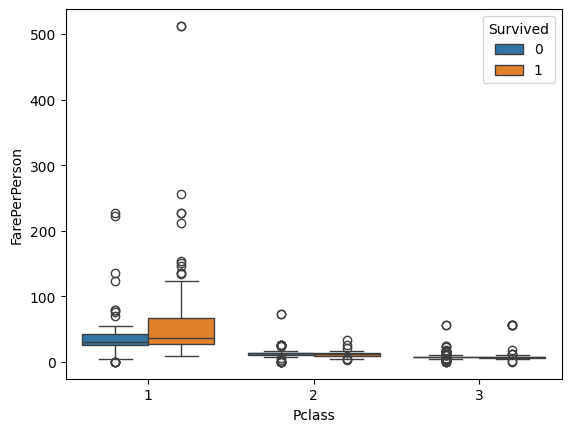

T-statistic: 6.775705408983137, P-value: 2.2513313600580802e-11


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Vẽ boxplot
sns.boxplot(x='Pclass', y='FarePerPerson', hue='Survived', data=train_df)
plt.show()

# Kiểm định thống kê (t-test)
survived_group = train_df[train_df['Survived'] == 1]['FarePerPerson']
not_survived_group = train_df[train_df['Survived'] == 0]['FarePerPerson']
t_stat, p_value = stats.ttest_ind(survived_group, not_survived_group)
print(f'T-statistic: {t_stat}, P-value: {p_value}')


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Định nghĩa các bước trong pipeline
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson']
categorical_features = ['Sex', 'Embarked', 'Deck', 'Title']

# Tiền xử lý các đặc trưng số
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Tiền xử lý các đặc trưng phân loại
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kết hợp các bước xử lý
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Huấn luyện mô hình Random Forest
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Tối ưu hóa siêu tham số với GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(train_df, train_df['Survived'])

print(f'Best parameters: {grid_search.best_params_}')


Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}


In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Đánh giá mô hình
y_pred = grid_search.predict(train_df)
print(classification_report(train_df['Survived'], y_pred))

# Đánh giá AUC ROC
roc_auc = roc_auc_score(train_df['Survived'], y_pred)
print(f'ROC-AUC: {roc_auc}')


              precision    recall  f1-score   support

           0       0.93      0.98      0.96       549
           1       0.97      0.89      0.93       342

    accuracy                           0.95       891
   macro avg       0.95      0.94      0.94       891
weighted avg       0.95      0.95      0.95       891

ROC-AUC: 0.936247723132969


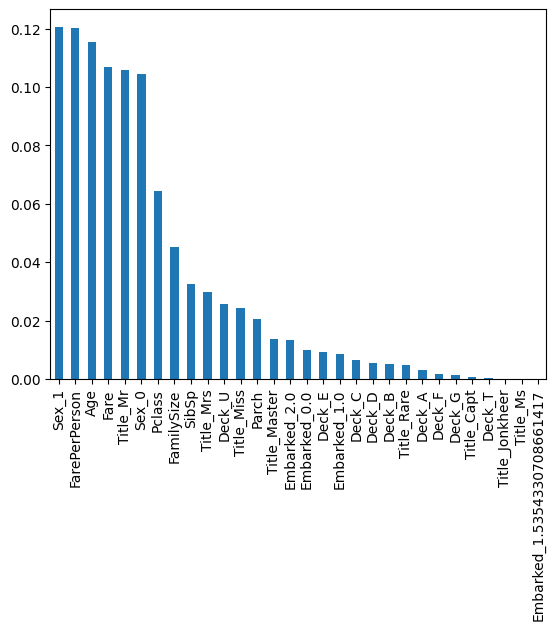

In [20]:
import numpy as np

# Feature importance
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
features = numeric_features + list(grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

# Vẽ feature importance
feature_importance.plot(kind='bar')
plt.show()
